In [3]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Suppress InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

In [92]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.pipeline import Pipeline
from GeneAnalysis import GeneAnalysis
import matplotlib.pyplot as plt

In [5]:
with open('Genes_plots/LeaveOneOut2_grid_search.pkl', 'rb') as file:
    loo_2 = pickle.load(file)

with open('Genes_plots/LeaveOneOut1_grid_search.pkl', 'rb') as file:
    loo_1 = pickle.load(file)

with open('Genes_plots/LeaveOneOut3_grid_search.pkl', 'rb') as file:
    loo_3 = pickle.load(file)
    
loo = [loo_1, loo_2, loo_3]

In [20]:
def create_ranked_lists(grid_search_results):

    cv_results = grid_search_results.cv_results_
    
    df = pd.DataFrame({
        'mean_fit_time': cv_results['mean_fit_time'],
        'mean_score_time': cv_results['mean_score_time'],
        'mean_test_f1': cv_results['mean_test_f1'],
        'params': cv_results['params']  
    })

    # Extract F1 scores
    f1_scores = cv_results.get('mean_test_f1', None)
    
    if f1_scores is not None:
        # Count how many have a perfect F1 score 
        perfect_f1_count = sum(1 for score in f1_scores if score == 1.0)
        if perfect_f1_count == 0:
            print("###### No models have F1 score of 1 ######")
            return None, None, None
        print(f"Number of models with a perfect F1 score: {perfect_f1_count}")


    # Filter out models that dont have perfect f1 score
    df_perfect_f1 = df[df['mean_test_f1'] == 1.0]

    # Rank models based on mean_score_time
    df_ranked_by_score_time = df_perfect_f1.sort_values(by='mean_score_time', ascending=True).reset_index(drop=True)

    # Rank models based on mean_fit_time
    df_ranked_by_fit_time = df_perfect_f1.sort_values(by='mean_fit_time', ascending=True).reset_index(drop=True)

    # Rank models based on the combined time
    df_combined = df_perfect_f1.copy()
    df_combined['combined_time'] = df_perfect_f1['mean_score_time'] + df_perfect_f1['mean_fit_time']
    df_ranked_by_combined_time = df_combined.sort_values(by='combined_time', ascending=True).reset_index(drop=True)


    return df_ranked_by_score_time, df_ranked_by_fit_time, df_ranked_by_combined_time

In [7]:
def load_gridsearch_results(filename):
    with open(filename, 'rb') as file:
        grid_search_results = pickle.load(file)
    
    return grid_search_results

In [59]:
def find_best_model_params_for_cv_method(cv_method, print_all=False):
    results = []
    if cv_method == 'loo':
        for i in [1,2,3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))
    
    best_by_combined_time={}

    for n, result in enumerate(results):
        if cv_method == 'loo':
            print(f"######## LOO NUMBER {n+1} ########")
        
        ranked_by_score_time, ranked_by_fit_time, ranked_by_combined_time = create_ranked_lists(result)
        if ranked_by_combined_time is None:
            continue
        
        if print_all:
            # Print Ranked by Mean Score Time
            print("Ranked by Mean Score Time:")
            print(ranked_by_score_time[['mean_score_time', 'mean_test_f1', 'params']])

            # Print Ranked by Mean Fit Time
            print("\nRanked by Mean Fit Time:")
            print(ranked_by_fit_time[['mean_fit_time', 'mean_test_f1', 'params']])

            # Print Ranked by Combined Time (mean_score_time + mean_fit_time)
            print("\nRanked by Combined Time:")
            print(ranked_by_combined_time[['combined_time', 'mean_test_f1', 'params']])
        if cv_method == 'loo':
            best_by_combined_time[n+1] = ranked_by_combined_time.iloc[0]

    if cv_method == 'loo':
        min_combined_time = 1000
        best_index = -1
        best_params = None
        for n in best_by_combined_time.keys():
            if best_by_combined_time[n]['combined_time'] < min_combined_time:
                min_combined_time = best_by_combined_time[n]['combined_time']
                best_index = n
                best_params = best_by_combined_time[n]
        print("BEST PARAMETERS IN TERMS OF COMBINED TIME:", best_params)
        return best_params
    else:
        print("BEST PARAMETERS IN TERMS OF COMBINED TIME:", ranked_by_combined_time.iloc[0])
        return ranked_by_combined_time.iloc[0]


In [60]:
best = find_best_model_params_for_cv_method('loo', print_all=False)

######## LOO NUMBER 1 ########
Number of models with a perfect F1 score: 3
######## LOO NUMBER 2 ########
###### No models have F1 score of 1 ######
######## LOO NUMBER 3 ########
Number of models with a perfect F1 score: 6
BEST PARAMETERS IN TERMS OF COMBINED TIME: mean_fit_time                                               0.248867
mean_score_time                                             0.111861
mean_test_f1                                                     1.0
params             {'classifier': KNeighborsClassifier(), 'classi...
combined_time                                               0.360728
Name: 0, dtype: object


In [24]:
genes = GeneAnalysis()

Data has been loaded.
Splitting train-test 80-20.


In [40]:
from sklearn.metrics import  make_scorer, accuracy_score, f1_score, confusion_matrix, roc_auc_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay

In [51]:

def evaluate_model_on_test_set(model):
    y_pred = model.predict(genes.X_test)
    y_pred_proba = model.predict_proba(genes.X_test)

    acc = accuracy_score(genes.y_test, y_pred)
    f1 = f1_score(genes.y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(genes.y_test, y_pred_proba, multi_class='ovo', average='weighted', labels=np.unique(genes.y_test))
    cm = confusion_matrix(genes.y_test, y_pred, labels=np.unique(genes.y_test))

    return acc, f1, roc_auc, cm

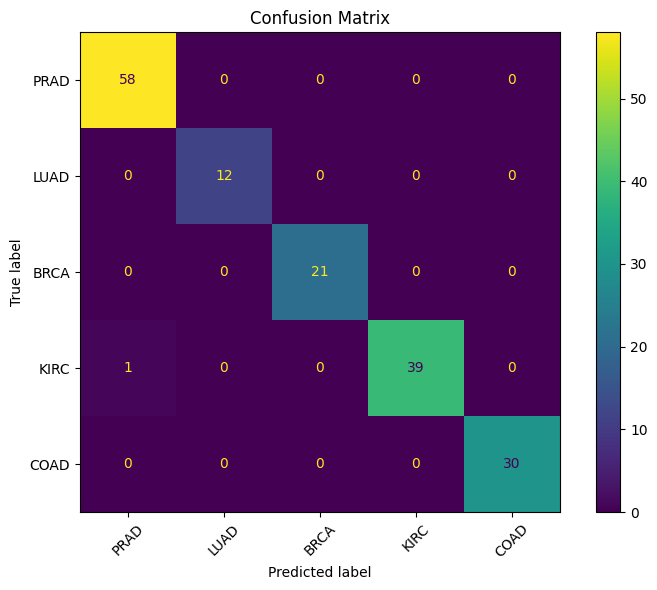

0.9937888198757764 0.9937760521139718 1.0


In [64]:
pipeline, _ = genes.get_pipeline_and_param_grid()
pipeline.set_params(**best.params)
model = pipeline.fit(genes.X_train, genes.y_train)
acc, f1, roc, cm = evaluate_model_on_test_set(model)
genes.plot_confusion_matrix(cm, show=True)
print(acc, f1, roc)

In [77]:
def find_best_reduced_dataset(cv_method):
    results = []
    if cv_method == 'loo':
        for i in [1,2,3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))

    cv_results = results[0].cv_results_
    
    df = pd.DataFrame({
        'mean_fit_time': cv_results['mean_fit_time'],
        'mean_score_time': cv_results['mean_score_time'],
        'mean_test_f1': cv_results['mean_test_f1'],
        'params': cv_results['params']  
    })

    results = []

    for index, row in df.iterrows():
        params = row['params']
        
        # Check if there is a feature extraction method that is NOT 'passthrough'
        if params.get('feature_selection', 'passthrough') != 'passthrough':
            # Extract relevant data
            feature_extraction_method = params['feature_selection']
            mean_fit_time = row['mean_fit_time']
            mean_score_time = row['mean_score_time']

            # Extract all hyperparameters related to the feature_selection step
            feature_selection_params = {key: val for key, val in params.items() if key.startswith('feature_selection__')}

            # Calculate combined score (fit + score time) and subtract the F1 score
            # Here we subtract F1 score to maximize it, as lower combined value is better
            combined_score = mean_fit_time + mean_score_time

            # Append the feature extraction method and combined score to the results list
            results.append({
                'feature_extraction': feature_extraction_method,
                'hyperparameters': feature_selection_params,
                'combined_score': combined_score
            })
    
    # Convert the list of results to a DataFrame
    results_df = pd.DataFrame(results)

    # Find the feature extraction method with the lowest combined score
    best_method = results_df.loc[results_df['combined_score'].idxmin()]

    return best_method

In [99]:
ds = find_best_reduced_dataset('loo')
print(ds['feature_extraction'])
(ds['hyperparameters'])

SelectKBest(score_func=<function mutual_info_classif at 0x00000247C0FE9700>)


{'feature_selection__k': 1000}

In [96]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
 

True

In [100]:
type(ds['feature_extraction']) == SelectKBest

True

In [105]:
def plot_feature_reduction_vs_accuracy(cv_method):
    results = []
    
    # Load results based on the specified cross-validation method
    if cv_method == 'loo':
        for i in [1, 2, 3]:
            results.append(load_gridsearch_results(f'Genes_plots/LeaveOneOut{i}_grid_search.pkl'))
    elif cv_method == 'No_cv':
        results.append(load_gridsearch_results('Genes_plots/No_cv_grid_search.pkl'))
    elif cv_method == 'KFold_3':
        results.append(load_gridsearch_results(f'Genes_plots/{cv_method}_grid_search.pkl'))

    # Combine results from different cross-validation methods
    cv_results = results[0].cv_results_
    
    df = pd.DataFrame({
        'mean_fit_time': cv_results['mean_fit_time'],
        'mean_score_time': cv_results['mean_score_time'],
        'mean_test_f1': cv_results['mean_test_f1'],
        'params': cv_results['params']  
    })

    # Initialize dictionaries to store accuracies based on components or features
    pca_results = {}
    mutual_info_results = {}

    for index, row in df.iterrows():
        params = row['params']
        mean_test_f1 = row['mean_test_f1']

        # Extract relevant feature extraction methods and their hyperparameters
        feature_extraction_method = params.get('feature_selection', 'passthrough')
        
        if type(feature_extraction_method) == PCA:
            n_components = params.get('feature_selection__n_components', None)
            if n_components is not None:
                if n_components not in pca_results:
                    pca_results[n_components] = []
                pca_results[n_components].append(mean_test_f1)

        elif type(feature_extraction_method) == SelectKBest:
            k = params.get('feature_selection__k', None)
            if k is not None:
                if k not in mutual_info_results:
                    mutual_info_results[k] = []
                mutual_info_results[k].append(mean_test_f1)
    print(pca_results)
    print(mutual_info_results)

    # Calculate average accuracies for PCA and Mutual Information
    pca_avg_accuracy = {k: np.mean(v) for k, v in pca_results.items()}
    mutual_info_avg_accuracy = {k: np.mean(v) for k, v in mutual_info_results.items()}

    # Plotting PCA Results
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(list(pca_avg_accuracy.keys()), list(pca_avg_accuracy.values()), marker='o')
    plt.title('PCA: Number of Components vs Accuracy')
    plt.xlabel('Number of Components')
    plt.ylabel('Average Accuracy (F1 Score)')
    plt.grid()
    
    # Plotting Mutual Information Results
    plt.subplot(1, 2, 2)
    plt.plot(list(mutual_info_avg_accuracy.keys()), list(mutual_info_avg_accuracy.values()), marker='o', color='orange')
    plt.title('Mutual Information: Top K Features vs Accuracy')
    plt.xlabel('Top K Features')
    plt.ylabel('Average Accuracy (F1 Score)')
    plt.grid()

    plt.tight_layout()
    plt.show()


{3: [0.9828359669970658, 0.9812471721588257, 0.9812471721588257, 0.9844052342821469, 0.9812471721588257, 0.9812471721588257, 0.9828359669970658, 0.9812471721588257, 0.9812471721588257, 0.984517227466792, 0.984517227466792, 0.9876343370612412, 0.9860729574420409, 0.9861684089329762, 0.9861684089329762, 0.20752171546685425, 0.9802868592970815, 0.6380084106421803, 0.9876343370612412, 0.9774974960975685, 0.9860028834996779], 20: [0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9953030337288814, 0.9953030337288814, 0.9953030337288814, 0.9953030337288814, 0.9953030337288814, 0.9953030337288814, 0.20752171546685425, 0.9937297474656841, 0.8650633319850703, 0.9984204878150429, 0.996858768242532, 0.9984204878150429], 50: [0.9922035078973045, 0.9937767941605019, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.9922035078973045, 0.99

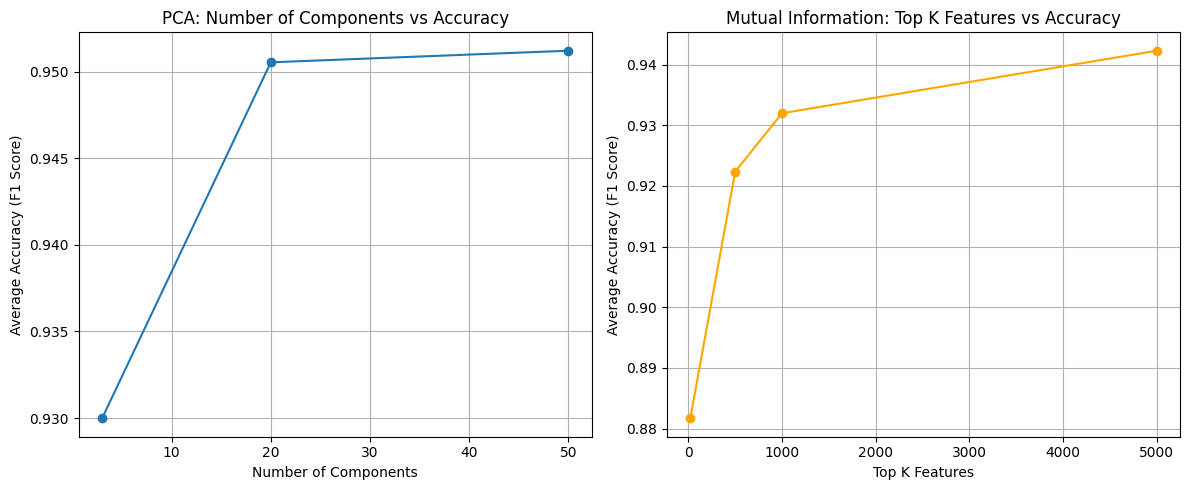

{3: [0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9922501485001485, 0.9768362971487972, 0.9844767501017502, 0.9768362971487972, 0.9768362971487972, 0.9768362971487972, 0.9768362971487972, 0.19001436781609196, 0.9771340811965812, 0.6672383130081301, 0.9768362971487972, 0.9697612359550563, 0.9768362971487972], 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19001436781609196, 1.0, 0.9842733662613982, 1.0, 1.0, 1.0], 50: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19001436781609196, 1.0, 0.9842733662613982, 1.0, 1.0, 1.0]}
{20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19001436781609196, 1.0, 0.19001436781609196, 1.0, 0.19001436781609196, 1.0], 500: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19001436781609196, 1.0, 0.2848356595632265, 1.

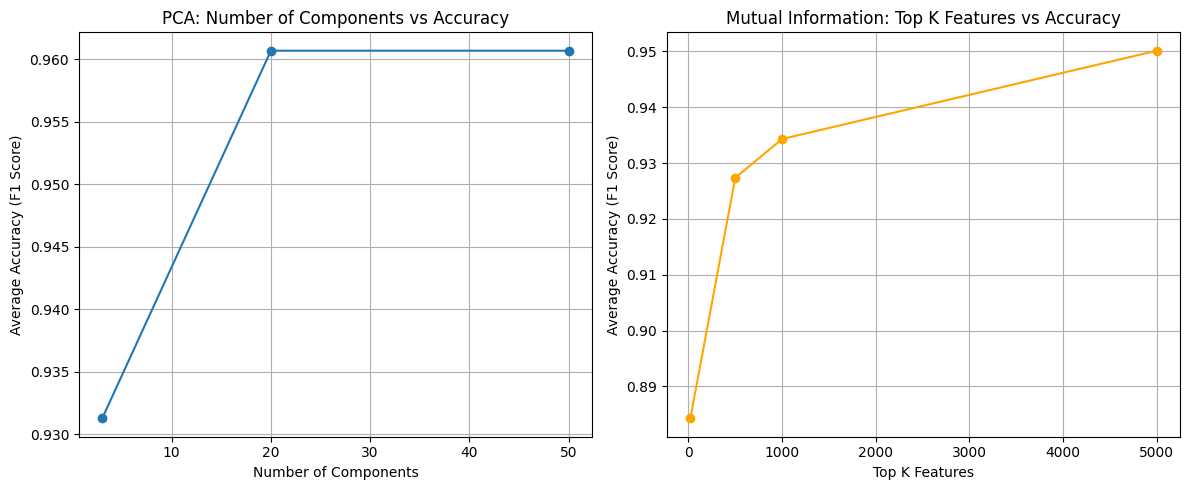

In [107]:
plot_feature_reduction_vs_accuracy('KFold_3')
plot_feature_reduction_vs_accuracy('No_cv')